# Part 2c - Logistic regression model for the probability of diverted US flights

In [2]:
#imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
plt.rc("font", size=14)

### The Data

In [4]:
#reading and joining the year csv to create one large dataframe
df = pd.concat([pd.read_csv(f"dataset/{year}.csv", encoding='latin-1') for year in range(1995,2005)])

/var/folders/kz/gkr3vj392y93zt9m0pdb0cr40000gn/T/ipykernel_95413/3445128161.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat([pd.read_csv(f"dataset/{year}.csv", encoding='latin-1') for year in range(1995,2005)])


In [5]:
planes = pd.read_csv("dataset/plane-data.csv")
airports = pd.read_csv("dataset/airports.csv")
carriers = pd.read_csv("dataset/carriers.csv")

In [6]:
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')

#### Input Variables
- Month (Categorical: 'Spring', 'Summer' etc) [Congestion]
- DayOfWeek (Categorical: 'Mon', 'Tue', 'Wed' etc) [Congestion]
- TimeOfDay (Categorical: 'Late Night', 'Early Morning' etc) [Congestion]
- Distance (Numerical: miles) [Fuel Considerations]
- CarrierDelayRate (Numerical: percentage) [Airline Issues]
- AirportDelayRate (Numerical: percentage) [Airport Issues]

#### Output Variable
- y: Diverted Plane (Binary: 0/1)

**Variables to Keep:**
- Month
- DayOfWeek
- CRSDepTime
- DepDelay (calculate rates)
- UniqueCarrier (to link with Carrier to get Airline name)
- Origin (to link with Airports to get Airport name)
- Distance

### Pre-processing

In [9]:
df = df[['Year','Diverted','Month','DayofMonth','DayOfWeek','CRSDepTime','DepDelay','UniqueCarrier','Origin','Distance']]

##### Data types

In [11]:
df.head()

,Year,Diverted,Month,DayofMonth,DayOfWeek,CRSDepTime,DepDelay,UniqueCarrier,Origin,Distance
0,1995,0,1,6,5,645,12.0,UA,ORD,678.0
1,1995,0,1,7,6,645,3.0,UA,ORD,678.0
2,1995,0,1,8,7,645,4.0,UA,ORD,678.0
3,1995,0,1,9,1,645,0.0,UA,ORD,678.0
4,1995,0,1,10,2,645,0.0,UA,ORD,678.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57543862 entries, 0 to 7129269
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Year           int64  
 1   Diverted       int64  
 2   Month          int64  
 3   DayofMonth     int64  
 4   DayOfWeek      int64  
 5   CRSDepTime     int64  
 6   DepDelay       float64
 7   UniqueCarrier  object 
 8   Origin         object 
 9   Distance       float64
dtypes: float64(2), int64(6), object(2)
memory usage: 4.7+ GB


##### Missing Data

In [14]:
df.isna().sum()

Year                   0
Diverted               0
Month                  0
DayofMonth             0
DayOfWeek              0
CRSDepTime             0
DepDelay         1330081
UniqueCarrier          0
Origin                 0
Distance            5987
dtype: int64

In [15]:
df = df.dropna()
df.isna().sum()

Year             0
Diverted         0
Month            0
DayofMonth       0
DayOfWeek        0
CRSDepTime       0
DepDelay         0
UniqueCarrier    0
Origin           0
Distance         0
dtype: int64

##### New Columns

In [17]:
df['Hour'] = df['CRSDepTime'] // 100
df[df['Hour']==24] = 0

In [18]:
#Carrier Delay Rate
rates = []
airlines = []
for code in df['UniqueCarrier'].unique():
    cond1 = df['DepDelay'] > 0
    cond2 = df['UniqueCarrier'] == code

    rate = round(len(df[cond1 & cond2])/len(df[cond2]),3)

    rates.append(rate)
    airlines.append(code)

AirlineRates = pd.DataFrame()
AirlineRates['UniqueCarrier'] = airlines
AirlineRates['CarrierDelayRate'] = rates

df = pd.merge(df,AirlineRates,on='UniqueCarrier', how='left')
del(rates, airlines, cond1, cond2, rate, AirlineRates)

In [19]:
#Airport Delay Rate
rates = []
airports = []

for code in df['Origin'].unique():
    cond1 = df['DepDelay'] > 0
    cond2 = df['Origin'] == code

    rate = round(len(df[cond1 & cond2])/len(df[cond2]),3)

    rates.append(rate)
    airports.append(code)

AirportRates = pd.DataFrame()
AirportRates['Origin'] = airports
AirportRates['AirportDelayRate'] = rates

df = pd.merge(df,AirportRates,on='Origin', how='left')
del(rates, airports, cond1, cond2, rate, AirportRates)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56207870 entries, 0 to 56207869
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Year              int64  
 1   Diverted          int64  
 2   Month             int64  
 3   DayofMonth        int64  
 4   DayOfWeek         int64  
 5   CRSDepTime        int64  
 6   DepDelay          float64
 7   UniqueCarrier     object 
 8   Origin            object 
 9   Distance          float64
 10  Hour              int64  
 11  CarrierDelayRate  float64
 12  AirportDelayRate  float64
dtypes: float64(4), int64(7), object(2)
memory usage: 5.4+ GB


In [21]:
df['Diverted'] = df['Diverted'].astype('category')
data = df[['Year','Diverted','Month','DayofMonth','DayOfWeek','Hour','Distance','CarrierDelayRate','AirportDelayRate']]

### Logistic Regression

In [188]:
def LogReg(df):
    #target variable and predictors
    y = df['Diverted']
    X = df.drop(['Diverted','Year'], axis = 1)

    #normalising data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    #split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=1)

    #train model
    lr = LogisticRegression(class_weight='balanced', random_state=1)
    lr.fit(X_train, y_train)
    y_predictions = lr.predict(X_test)

    #return model
    return lr, lr.coef_[0]

In [196]:
lrs = []
coefs = []
xcols = ['Month','DayofMonth','DayOfWeek','Hour','Distance','CarrierDelayRate','AirportDelayRate'] * 10
years = [year for year in range(1995, 2005) for var in range(7)]

for year in range(1995,2005):
    lr, coef = LogReg(data[data['Year']==year])
    coefs.extend(coef)
    lrs.append(lr)

In [197]:
results = pd.DataFrame()
results['Year'] = years
results['Predictor'] = xcols
results['Coef'] = coefs

### Visualisation

/var/folders/kz/gkr3vj392y93zt9m0pdb0cr40000gn/T/ipykernel_92359/3719116329.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/kz/gkr3vj392y93zt9m0pdb0cr40000gn/T/ipykernel_92359/3719116329.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/kz/gkr3vj392y93zt9m0pdb0cr40000gn/T/ipykernel_92359/3719116329.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/kz/gkr3vj392y93zt9m0pdb0cr40000gn/T/ipykernel_92359/3719116329.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

<Figure size 1600x400 with 0 Axes>

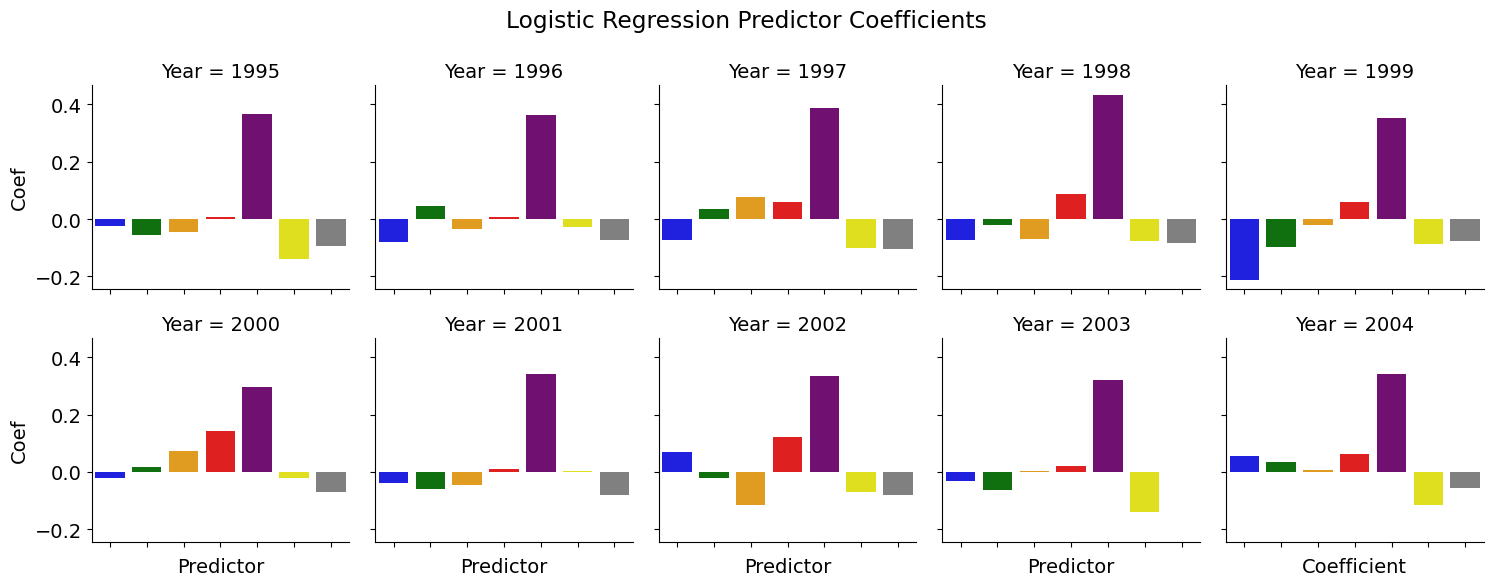

{'Month': 'blue', 'DayofMonth': 'green', 'DayOfWeek': 'orange', 'Hour': 'red', 'Distance': 'purple', 'CarrierDelayRate': 'yellow', 'AirportDelayRate': 'grey'}


In [274]:
palette = {'Month': 'blue', 'DayofMonth': 'green', 'DayOfWeek': 'orange', 'Hour': 'red',
           'Distance': 'purple', 'CarrierDelayRate': 'yellow', 'AirportDelayRate': 'grey'}

plt.figure(figsize=(16, 4))

g = sns.FacetGrid(results, col='Year', col_wrap=5)
g.map_dataframe(sns.barplot, x='Predictor', y='Coef',hue='Predictor', palette=palette)
g.add_legend()

plt.xlabel('Coefficient')
plt.ylabel('Predictors')

for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle("Logistic Regression Predictor Coefficients")
plt.tight_layout()
plt.show()
print(palette)

##### Confusion Matrix

In [36]:
#target variable and predictors
y = data['Diverted']
X = data.drop(['Diverted','Year'], axis = 1)

#normalising data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=1)

#train model
lr = LogisticRegression(class_weight='balanced', random_state=1)
lr.fit(X_train, y_train)
y_predictions = lr.predict(X_test)

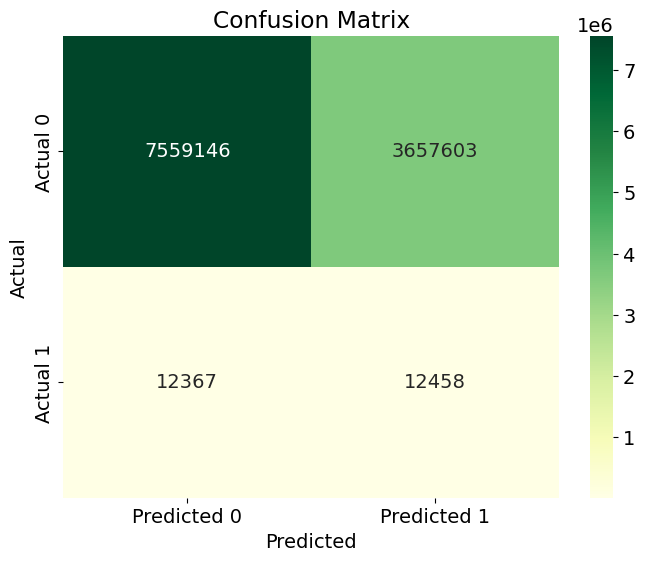

              precision    recall  f1-score   support

           0       1.00      0.67      0.80  11216749
           1       0.00      0.50      0.01     24825

    accuracy                           0.67  11241574
   macro avg       0.50      0.59      0.41  11241574
weighted avg       1.00      0.67      0.80  11241574



In [43]:
cm = confusion_matrix(y_test, y_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

print(classification_report(y_test,y_predictions))

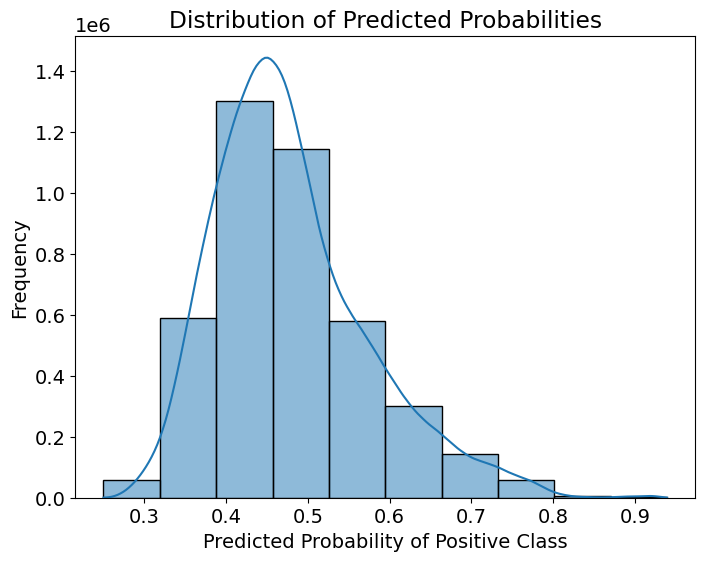

In [55]:
y_proba = lr.predict_proba(X_train)

# Extract probabilities for the positive class (assuming binary classification)
y_proba_positive = y_proba[:, 1]

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_proba_positive, kde=True, bins=10)
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

In [39]:
print(classification_report(y_test,y_prediction))

/Users/shuayb/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1043846
           1       0.00      0.00      0.00      2078

    accuracy                           1.00   1045924
   macro avg       0.50      0.50      0.50   1045924
weighted avg       1.00      1.00      1.00   1045924



/Users/shuayb/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shuayb/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
coefficients = lr.coef_[0]
coefficients

In [51]:
accuracy = accuracy_score(y_test, y_prediction)
accuracy

0.6592687422795538

In [ ]:
# Get the feature coefficients
coefficients = lr.coef_[0]

# Print the coefficients
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef}")